# STM Transit Delay Data Preparation

## Overview

This notebook cleans and merges data collected from [STM](https://www.stm.info/en/about/developers), [Open-Meteo](https://open-meteo.com/en/docs) and [Tomtom](https://developer.tomtom.com/) and prepares it for data analysis and/or preprocessing.

## Data Description

### STM Real-time Trip Updates

`current_time`: Timestamp when the data was fetched from the GTFS, in milliseconds.<br>
`trip_id`: Unique identifier for the transit trip.<br>
`route_id`: Unique identifier for a bus or metro line.<br>
`start_date`: Start date of the transit trip.<br>
`stop_id`: Unique identifier of a stop.<br>
`arrival_time`, `departure_time`: Realtime arrival and departure time, in seconds<br>
`schedule_relationship`: State of the trip, 0 meaning "scheduled", 1 meaning "skipped" and 2 meaning "no data".

### STM Scheduled Trips

`trip_id`: Unique identifier for the transit trip.<br>
`arrival_time`, `departure_time`: Scheduled arrival and departure time.<br>
`stop_id`: Unique identifier of a stop.<br>
`stop_sequence`: Sequence of a stop, for ordering.

### STM Stops

`stop_id`: Unique identifier of a stop.<br>
`stop_code`: Bus stop or metro station number.<br>
`stop_name`: Bus stop or metro station name<br>
`stop_lat`, `stop_lon`: Stop coordinates.<br>
`stop_url`: Stop web page.<br>
`location_type`: Stop type.<br>
`parent_station`: Parent station (metro station with multiple exits).<br>
`wheelchair_boarding`: Indicates if the stop is accessible for people in wheelchair, 1 being true and 2 being false.

### STM Real-time Vehicle Positions

`current_time`: Timestamp when the data was fetched from the GTFS, in milliseconds.<br>
`vehicle_id`: Unique identifier for a vehicle.<br>
`trip_id`: Unique identifier for the transit trip.<br>
`route_id`: Unique identifier for a bus or metro line.<br>
`start_date`: Start date of a transit trip.<br>
`start_time`: Start time of a transit trip.<br>
`latitude`, `longitude`: Vehicle current position.<br>
`bearing`: Direction that the vehicle is facing, from 0 to 360 degrees.<br>
`speed`: Momentary speed measured by the vehicle, in meters per second.<br>
`stop_sequence`: Refers to the stop that the vehicle is either on its way to, or already stopped at.<br>
`status`: Vehicle stop status in relation with a stop that it's currently approaching or is at, 1 being "stopped at" and 2 being "in transit to".<br>
`timestamp`: Timestamp when STM updated the data, in seconds.<br>
`occupancy_status`: Degree of passenger occupancy, ranging from 1 (empty) to 7 (not accepting passengers).

### STM Service Alerts

`start_time`: Start time of the alert, in seconds.<br>
`end_time`: End time of the alert, in seconds.<br>
`route_id`: Unique identifier for a bus or metro line.<br>
`stop_id`: Unique identifier of a stop.

### STM Route Types

`route_id`: Unique identifier for a bus or metro line.<br>
`route_type`: Type of bus line (e.g. Night)<br>

### Open-Meteo Weather Archive

`time`: Date and hour or the weather.<br>
`temperature`: Air temperature at 2 meters above ground, in Celsius.<br>
`relative_humidity`: Relative humidity at 2 meters above ground, in percentage.<br>
`dew_point`: Dew point temperature at 2 meters above ground, in Celsius.<br>
`precipitation`: Total precipitation (rain, showers, snow) sum of the preceding hour, in millimeters.<br>
`pressure`: Atmospheric air pressure reduced to mean sea level (msl), in hPa.<br>
`visibility`: Viewing distance in meters.<br>
`cloud_cover`: Total cloud cover as an area fraction.<br>
`windspeed`: Wind speed at 10 meters above ground, in kilometers per hour.<br>
`wind_direction`: Wind direction at 10 meters above ground.<br>
`wind_gusts`: Gusts at 10 meters above ground as a maximum of the preceding hour.<br>

### Tomtom Traffic Incidents

`category`: Category of the incident.<br>
`start_time`: Start time of the incident, in ISO8601 format.<br>
`end_time`: End time of the incident, in ISO8601 format.<br>
`length`: Length of the incident in meters.<br>
`delay`: Delay in seconds caused by the incident (except road closures).<br>
`magnitude_of_delay`: Severity of the delay, ranging from 0 to 4 (minor to major).<br>
`last_report_time`: Date when the last time the incident was reported,in ISO8601 format.<br>
`latitude`, `longitude`: Coordinates of the incident.

## Imports

In [1]:
from datetime import datetime, timedelta, timezone
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys

In [2]:
# Import custom code
sys.path.insert(0, '..')
from scripts.custom_functions import fetch_weather, LOCAL_TIMEZONE, OCCUPANCY_STATUS, SCHEDULE_RELATIONSHIP

In [3]:
# Import data
trips_df = pd.read_csv('../data/api/fetched_stm_trip_updates.csv',low_memory=False)
schedules_df = pd.read_csv('../data/download/stop_times_2025-04-30.txt')
stops_df = pd.read_csv('../data/download/stops_2025-04-30.txt')
positions_df =  pd.read_csv('../data/api/fetched_stm_vehicle_positions.csv', low_memory=False)
alerts_df = pd.read_csv('../data/api/fetched_stm_service_alerts.csv')
routes_df = pd.read_csv('../data/route_types.csv')
traffic_df = pd.read_csv('../data/api/fetched_traffic.csv')
weather_df = pd.read_csv('../data/api/fetched_historical_weather.csv')

## Merge Data

### Schedules and stops

In [4]:
# Sort values by stop sequence
schedules_df = schedules_df.sort_values(by=['trip_id', 'stop_sequence'])

In [5]:
# Add trip progress (vehicles further along the trip are more likely to be delayed)
total_stops = schedules_df.groupby('trip_id')['stop_id'].transform('count')
schedules_df['trip_progress'] = schedules_df['stop_sequence'] / total_stops

In [6]:
# Get distribution of trip progress
schedules_df['trip_progress'].describe()

count    6.629625e+06
mean     5.139220e-01
std      2.887289e-01
min      8.547009e-03
25%      2.631579e-01
50%      5.142857e-01
75%      7.647059e-01
max      1.000000e+00
Name: trip_progress, dtype: float64

In [7]:
# Merge schedules and stops
schedules_stops_df = pd.merge(left=schedules_df, right=stops_df, how='inner', left_on='stop_id', right_on='stop_code') \
	.rename(columns={'stop_id_x': 'stop_id'}) \
	.drop(['stop_id_y', 'stop_code', 'stop_url'], axis=1)

In [8]:
schedules_stops_df.columns

Index(['trip_id', 'arrival_time', 'departure_time', 'stop_id', 'stop_sequence',
       'trip_progress', 'stop_name', 'stop_lat', 'stop_lon', 'location_type',
       'parent_station', 'wheelchair_boarding'],
      dtype='object')

In [9]:
# Get coordinates of previous stop
schedules_stops_df = schedules_stops_df.sort_values(by=['trip_id', 'stop_sequence'])
schedules_stops_df['prev_lat'] = schedules_stops_df.groupby('trip_id')['stop_lat'].shift(1)
schedules_stops_df['prev_lon'] = schedules_stops_df.groupby('trip_id')['stop_lon'].shift(1)

In [10]:
# Get previous stop_id
schedules_stops_df['prev_stop_id'] = schedules_stops_df.groupby('trip_id')['stop_id'].shift(1)

In [11]:
# Make sure scheduled arrival time has no null values
assert schedules_stops_df['arrival_time'].isna().sum() == 0

In [12]:
# Get arrival and departure time of previous stop
schedules_stops_df['prev_time'] = schedules_stops_df.groupby('trip_id')['arrival_time'].shift(1)

In [13]:
# Make sure the null coordinates are from first stops
prev_null_mask = (schedules_stops_df['prev_lat'].isna()) | (schedules_stops_df['prev_lon'].isna())
first_stop_mask = schedules_stops_df['stop_sequence'] == 1
assert prev_null_mask.sum() == first_stop_mask.sum()

In [14]:
def parse_gtfs_time(df:pd.DataFrame, date_column:str, time_column:str, milliseconds:bool=True) -> pd.Series:
	'''
	Converts GTFS time string (e.g., '25:30:00') to localized datetime
	based on the arrival or departure time.
	'''
	time_columns = ['hours', 'minutes', 'seconds']
	split_cols = df[time_column].str.split(':', expand=True).apply(pd.to_numeric)
	split_cols.columns = time_columns
	seconds_delta = (split_cols['hours'] * 3600) + (split_cols['minutes'] * 60) + split_cols['seconds']
	
	# Convert datetime to seconds
	if milliseconds:
		start_seconds = df[date_column].astype('int') / 10**9
	else:# microseconds
		start_seconds = df[date_column].astype('int') / 10**6

	# Add seconds 
	total_seconds = start_seconds + seconds_delta

	# Convert to datetime
	parsed_time = pd.to_datetime(total_seconds, origin='unix', unit='s').dt.tz_localize(LOCAL_TIMEZONE)

	return parsed_time

In [15]:
# Add column with current date
schedules_stops_df['today'] = datetime.now().replace(hour=0, minute=0, second=0, microsecond=0)
schedules_stops_df['today'].head()

0   2025-05-07
1   2025-05-07
2   2025-05-07
3   2025-05-07
4   2025-05-07
Name: today, dtype: datetime64[us]

In [16]:
schedules_stops_df['parsed_time'] = parse_gtfs_time(schedules_stops_df, 'today', 'arrival_time', False)
schedules_stops_df['parsed_time'].head()

0   2025-05-07 04:55:00-04:00
1   2025-05-07 04:55:31-04:00
2   2025-05-07 04:56:04-04:00
3   2025-05-07 04:56:31-04:00
4   2025-05-07 04:56:51-04:00
Name: parsed_time, dtype: datetime64[ns, Canada/Eastern]

In [17]:
schedules_stops_df['parsed_prev_time'] = parse_gtfs_time(schedules_stops_df, 'today', 'prev_time', False)
schedules_stops_df['parsed_prev_time'].head()

0                         NaT
1   2025-05-07 04:55:00-04:00
2   2025-05-07 04:55:31-04:00
3   2025-05-07 04:56:04-04:00
4   2025-05-07 04:56:31-04:00
Name: parsed_prev_time, dtype: datetime64[ns, Canada/Eastern]

In [18]:
# Calculate expected trip duration
schedules_stops_df['trip_start'] = schedules_stops_df.groupby('trip_id')['parsed_time'].transform('min')
schedules_stops_df['trip_end'] = schedules_stops_df.groupby('trip_id')['parsed_time'].transform('max')
schedules_stops_df['exp_trip_duration'] = (schedules_stops_df['trip_end'] - schedules_stops_df['trip_start']) / pd.Timedelta(seconds=1)

In [19]:
# Get distribution
schedules_stops_df['exp_trip_duration'].describe()

count    6.388741e+06
mean     2.514089e+03
std      8.689949e+02
min      2.400000e+02
25%      1.860000e+03
50%      2.460000e+03
75%      3.120000e+03
max      6.840000e+03
Name: exp_trip_duration, dtype: float64

In [20]:
# Calculate expected delay between previous and current stop
schedules_stops_df['exp_delay_prev_stop'] = (schedules_stops_df['parsed_time'] - schedules_stops_df['parsed_prev_time']) / pd.Timedelta(seconds=1)

In [21]:
# Get distribution
schedules_stops_df['exp_delay_prev_stop'].describe()

count    6.216518e+06
mean     6.134963e+01
std      6.562132e+01
min      3.000000e+00
25%      3.500000e+01
50%      4.900000e+01
75%      6.800000e+01
max      2.220000e+03
Name: exp_delay_prev_stop, dtype: float64

In [22]:
# Assert that the null values are from first stops
assert (schedules_stops_df['stop_sequence'] == 1).sum() == schedules_stops_df['exp_delay_prev_stop'].isna().sum()

In [23]:
# Fill null values with 0 (first stop)
schedules_stops_df['exp_delay_prev_stop'] = schedules_stops_df['exp_delay_prev_stop'].fillna(0)

In [24]:
# Create GeoDataFrames for previous and current stop
sch_gdf1 = gpd.GeoDataFrame(
  schedules_stops_df[['prev_lon', 'prev_lat']],
  geometry=gpd.points_from_xy(schedules_stops_df['prev_lon'], schedules_stops_df['prev_lat']),
  crs='EPSG:4326' # WGS84 (sea level)
).to_crs(epsg=3857) # Convert to metric for buffering (meters)

sch_gdf2 = gpd.GeoDataFrame(
  schedules_stops_df[['stop_lon', 'stop_lat']],
  geometry=gpd.points_from_xy(schedules_stops_df['stop_lon'], schedules_stops_df['stop_lat']),
  crs='EPSG:4326'
).to_crs(epsg=3857)

In [25]:
# Calculate distance from previous stop
schedules_stops_df['stop_distance'] = sch_gdf1.distance(sch_gdf2)
schedules_stops_df['stop_distance'].describe()

count    6.216518e+06
mean     4.019345e+02
std      7.161721e+02
min      2.092191e+01
25%      2.490739e+02
50%      3.286372e+02
75%      4.299291e+02
max      1.965439e+04
Name: stop_distance, dtype: float64

In [26]:
# Replace null distances by zero (first stop of the trip)
schedules_stops_df['stop_distance'] = schedules_stops_df['stop_distance'].fillna(0)
assert schedules_stops_df['stop_distance'].isna().sum() == 0

In [27]:
# Get stop with largest distance
schedules_stops_df.iloc[schedules_stops_df['stop_distance'].idxmax()]

trip_id                                    281377832
arrival_time                                05:33:00
departure_time                              05:33:00
stop_id                                        61261
stop_sequence                                     13
trip_progress                                    1.0
stop_name              YUL Aéroport Montréal-Trudeau
stop_lat                                   45.456622
stop_lon                                  -73.751615
location_type                                      0
parent_station                                   NaN
wheelchair_boarding                                1
prev_lat                                   45.482527
prev_lon                                  -73.578964
prev_stop_id                                 61334.0
prev_time                                   05:12:00
today                            2025-05-07 00:00:00
parsed_time                2025-05-07 05:33:00-04:00
parsed_prev_time           2025-05-07 05:12:00

The large distance make sense because the expected time between the the previous stop and this one is 21 minutes.

In [28]:
schedules_stops_df.columns

Index(['trip_id', 'arrival_time', 'departure_time', 'stop_id', 'stop_sequence',
       'trip_progress', 'stop_name', 'stop_lat', 'stop_lon', 'location_type',
       'parent_station', 'wheelchair_boarding', 'prev_lat', 'prev_lon',
       'prev_stop_id', 'prev_time', 'today', 'parsed_time', 'parsed_prev_time',
       'trip_start', 'trip_end', 'exp_trip_duration', 'exp_delay_prev_stop',
       'stop_distance'],
      dtype='object')

In [29]:
# Drop unneeded columns
schedules_stops_df = schedules_stops_df.drop([
  'prev_lat',
  'prev_lon',
  'prev_time',
  'today',
  'parsed_time',
  'parsed_prev_time',
  'trip_start', 
  'trip_end',
  ], axis=1)

### Realtime and Scheduled Trips

In [30]:
# Convert route_id to integer
trips_df['route_id'] = trips_df['route_id'].str.extract(r'(\d+)')
trips_df['route_id'] = trips_df['route_id'].astype('int64')

In [31]:
# Get proportion of duplicates
subset = trips_df.drop('current_time', axis=1).columns
duplicate_mask = trips_df.duplicated(subset=subset)
print(f'{duplicate_mask.mean():.2%}')

10.19%


In [32]:
# Remove duplicates
trips_df = trips_df.drop_duplicates(subset=subset, keep='last')

In [33]:
# Rename arrival and departure time
trips_df = trips_df.rename(columns={'arrival_time': 'rt_arrival_time','departure_time': 'rt_departure_time'})

In [34]:
# Merge trip updates with schedule
stm_trips_df = pd.merge(left=trips_df, right=schedules_stops_df, how='inner', on=['trip_id', 'stop_id'])

In [35]:
stm_trips_df.columns

Index(['current_time', 'trip_id', 'route_id', 'start_date', 'stop_id',
       'rt_arrival_time', 'rt_departure_time', 'schedule_relationship',
       'arrival_time', 'departure_time', 'stop_sequence', 'trip_progress',
       'stop_name', 'stop_lat', 'stop_lon', 'location_type', 'parent_station',
       'wheelchair_boarding', 'prev_stop_id', 'exp_trip_duration',
       'exp_delay_prev_stop', 'stop_distance'],
      dtype='object')

In [36]:
# Convert start_date to datetime
stm_trips_df['start_date_dt'] = pd.to_datetime(stm_trips_df['start_date'], format='%Y%m%d')

In [37]:
# Parse GTFS scheduled arrival and departure times
parsed_arrival_time = parse_gtfs_time(stm_trips_df, 'start_date_dt', 'arrival_time')
parsed_departure_time = parse_gtfs_time(stm_trips_df, 'start_date_dt', 'departure_time')

In [38]:
# Convert scheduled arrival and departure time to UTC datetime
stm_trips_df['sch_arrival_time'] = parsed_arrival_time.dt.tz_convert(timezone.utc)
stm_trips_df['sch_departure_time'] = parsed_departure_time.dt.tz_convert(timezone.utc)

In [39]:
# Get rows where scheduled arrival and departure time are different
stm_trips_df[stm_trips_df['sch_arrival_time'] != stm_trips_df['sch_departure_time']]

,current_time,trip_id,route_id,start_date,stop_id,rt_arrival_time,rt_departure_time,schedule_relationship,arrival_time,departure_time,...,location_type,parent_station,wheelchair_boarding,prev_stop_id,exp_trip_duration,exp_delay_prev_stop,stop_distance,start_date_dt,sch_arrival_time,sch_departure_time
5232,1.745791e+09,284216122,470,20250427,57794,1745792340,1745792340,0,18:19:00,18:20:00,...,0,NaN,1,57620.0,2640.0,95.0,391.127323,2025-04-27,2025-04-27 22:19:00+00:00,2025-04-27 22:20:00+00:00
10326,1.745791e+09,284216100,470,20250427,60415,1745792054,1745792054,0,18:06:00,18:07:00,...,0,NaN,1,57818.0,3060.0,77.0,782.045238,2025-04-27,2025-04-27 22:06:00+00:00,2025-04-27 22:07:00+00:00
10754,1.745791e+09,284216575,747,20250427,60997,0,1745791860,0,18:06:00,18:11:00,...,0,NaN,1,NaN,2940.0,0.0,0.000000,2025-04-27,2025-04-27 22:06:00+00:00,2025-04-27 22:11:00+00:00
11788,1.745791e+09,284216533,747,20250427,60997,0,1745794440,0,18:49:00,18:54:00,...,0,NaN,1,NaN,2820.0,0.0,0.000000,2025-04-27,2025-04-27 22:49:00+00:00,2025-04-27 22:54:00+00:00
12297,1.745791e+09,284216124,470,20250427,60415,1745795640,1745795700,0,19:14:00,19:15:00,...,0,NaN,1,57818.0,2940.0,74.0,782.045238,2025-04-27,2025-04-27 23:14:00+00:00,2025-04-27 23:15:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6649090,1.746652e+09,284780060,470,20250507,60415,1746653880,1746654120,0,17:38:00,17:42:00,...,0,NaN,1,57818.0,3600.0,94.0,782.045238,2025-05-07,2025-05-07 21:38:00+00:00,2025-05-07 21:42:00+00:00
6649118,1.746652e+09,284727170,18,20250507,53851,1746652740,1746652860,0,17:19:00,17:21:00,...,0,NaN,1,51511.0,3780.0,106.0,271.004292,2025-05-07,2025-05-07 21:19:00+00:00,2025-05-07 21:21:00+00:00
6649511,1.746652e+09,284726744,161,20250507,50820,1746653820,1746653940,0,17:37:00,17:39:00,...,0,NaN,1,50866.0,3300.0,64.0,449.523333,2025-05-07,2025-05-07 21:37:00+00:00,2025-05-07 21:39:00+00:00
6650217,1.746652e+09,284738851,469,20250507,53757,0,1746651960,0,17:04:00,17:06:00,...,0,NaN,1,NaN,2280.0,0.0,0.000000,2025-05-07,2025-05-07 21:04:00+00:00,2025-05-07 21:06:00+00:00


In [40]:
# Replace 0 timestamps with NaN
stm_trips_df['rt_arrival_time'] = stm_trips_df['rt_arrival_time'].replace({0: np.nan})
stm_trips_df['rt_departure_time'] = stm_trips_df['rt_departure_time'].replace({0: np.nan})

In [41]:
# Convert realtime arrival and departure time to UTC datetime
stm_trips_df['rt_arrival_time'] = pd.to_datetime(stm_trips_df['rt_arrival_time'], origin='unix', unit='s', utc=True)
stm_trips_df['rt_departure_time'] = pd.to_datetime(stm_trips_df['rt_departure_time'], origin='unix', unit='s', utc=True)

In [42]:
# Calculate delay (realtime - scheduled)
# Start with arrival time, if null, calculate with departure time
stm_trips_df['delay'] = (stm_trips_df['rt_arrival_time'] - stm_trips_df['sch_arrival_time']) / pd.Timedelta(seconds=1)
stm_trips_df['delay'] = stm_trips_df['delay'].fillna(((stm_trips_df['rt_departure_time'] - stm_trips_df['sch_departure_time']) / pd.Timedelta(seconds=1)))

In [43]:
# Get distribution
stm_trips_df['delay'].describe()

count    6.478460e+06
mean     6.620446e+01
std      4.716040e+02
min     -1.359200e+04
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      5.458500e+04
Name: delay, dtype: float64

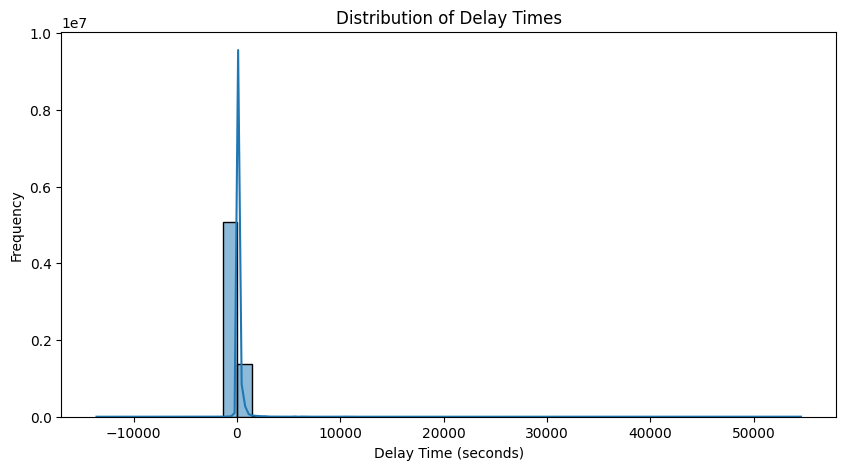

In [44]:
# Plot histogram
plt.figure(figsize=(10, 5))
sns.histplot(stm_trips_df['delay'], bins=50, kde=True)
plt.title('Distribution of Delay Times')
plt.xlabel('Delay Time (seconds)')
plt.ylabel('Frequency')
plt.savefig('../images/delay_histogram.png', bbox_inches='tight')
plt.show()

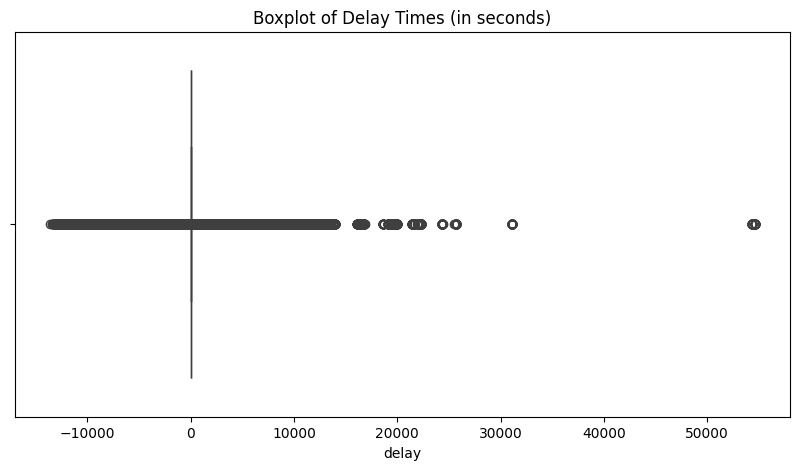

In [45]:
# Plot boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x=stm_trips_df['delay'])
plt.title('Boxplot of Delay Times (in seconds)')
plt.savefig('../images/delay_boxplot.png', bbox_inches='tight')
plt.show()

The distribution of delay times is highly skewed, with most values concentrated near 0, but extending both negatively and positively in a wide range. There are extreme outliers stretching up to 55000 seconds (more than 15 hours) and also negative values going beyond -10000 seconds (almost 3 hours). Such extreme alues are unrealistic for transit delays. It's very likely they represent data entry errors, sensor glitches or edge cases (canceled trips, detours, etc.).

In [ ]:
# Get rows where delay is bigger than a quarter of the expected trip duration
outlier_mask = np.abs(stm_trips_df['delay']) > (stm_trips_df['exp_trip_duration'] * 0.25)
outliers_df = stm_trips_df[outlier_mask]

In [47]:
outliers_df

,current_time,trip_id,route_id,start_date,stop_id,rt_arrival_time,rt_departure_time,schedule_relationship,arrival_time,departure_time,...,parent_station,wheelchair_boarding,prev_stop_id,exp_trip_duration,exp_delay_prev_stop,stop_distance,start_date_dt,sch_arrival_time,sch_departure_time,delay
216,1.745791e+09,284215152,160,20250427,50927,2025-04-27 22:00:48+00:00,2025-04-27 22:00:48+00:00,0,17:42:11,17:42:11,...,NaN,1,50886.0,2400.0,53.0,295.468070,2025-04-27,2025-04-27 21:42:11+00:00,2025-04-27 21:42:11+00:00,1117.0
217,1.745791e+09,284215152,160,20250427,50969,2025-04-27 22:02:23+00:00,2025-04-27 22:02:23+00:00,0,17:43:44,17:43:44,...,NaN,1,50927.0,2400.0,93.0,527.659038,2025-04-27,2025-04-27 21:43:44+00:00,2025-04-27 21:43:44+00:00,1119.0
218,1.745791e+09,284215152,160,20250427,51023,2025-04-27 22:03:39+00:00,2025-04-27 22:03:39+00:00,0,17:45:00,17:45:00,...,NaN,1,50969.0,2400.0,76.0,431.480956,2025-04-27,2025-04-27 21:45:00+00:00,2025-04-27 21:45:00+00:00,1119.0
219,1.745791e+09,284215152,160,20250427,51002,2025-04-27 22:04:01+00:00,2025-04-27 22:04:01+00:00,0,17:45:22,17:45:22,...,NaN,1,51023.0,2400.0,22.0,123.919000,2025-04-27,2025-04-27 21:45:22+00:00,2025-04-27 21:45:22+00:00,1119.0
220,1.745791e+09,284215152,160,20250427,50952,2025-04-27 22:04:35+00:00,2025-04-27 22:04:35+00:00,0,17:45:56,17:45:56,...,NaN,1,51002.0,2400.0,34.0,235.679815,2025-04-27,2025-04-27 21:45:56+00:00,2025-04-27 21:45:56+00:00,1119.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6646855,1.746652e+09,285002059,100,20250507,50671,2025-05-07 21:24:08+00:00,2025-05-07 21:24:08+00:00,0,17:00:38,17:00:38,...,NaN,1,50665.0,3180.0,39.0,175.527283,2025-05-07,2025-05-07 21:00:38+00:00,2025-05-07 21:00:38+00:00,1410.0
6646856,1.746652e+09,285002059,100,20250507,50720,2025-05-07 21:24:42+00:00,2025-05-07 21:24:42+00:00,0,17:01:12,17:01:12,...,NaN,1,50671.0,3180.0,34.0,152.957187,2025-05-07,2025-05-07 21:01:12+00:00,2025-05-07 21:01:12+00:00,1410.0
6646857,1.746652e+09,285002059,100,20250507,50734,2025-05-07 21:25:30+00:00,2025-05-07 21:25:30+00:00,0,17:02:00,17:02:00,...,NaN,1,50720.0,3180.0,48.0,213.610163,2025-05-07,2025-05-07 21:02:00+00:00,2025-05-07 21:02:00+00:00,1410.0
6646858,1.746652e+09,285002059,100,20250507,50769,2025-05-07 21:29:30+00:00,NaT,0,17:06:00,17:06:00,...,NaN,1,50734.0,3180.0,240.0,306.794736,2025-05-07,2025-05-07 21:06:00+00:00,2025-05-07 21:06:00+00:00,1410.0


In [48]:
# Calculate proportion
print(f'{outlier_mask.mean():.2%}')

1.86%


In [49]:
# Remove outliers (less than 2%)
stm_trips_df = stm_trips_df[~outlier_mask]

In [50]:
# Get null delays count
print(stm_trips_df['delay'].isna().sum())

172197


In [51]:
# Replace the null delays with the average delay by route, stop, day of week and hour
stm_trips_df['day_of_week'] = stm_trips_df['sch_arrival_time'].dt.day_of_week
stm_trips_df['hour'] = stm_trips_df['sch_arrival_time'].dt.hour
stm_trips_df['delay'] = stm_trips_df['delay'] \
	.fillna(stm_trips_df.groupby(['route_id', 'stop_id', 'day_of_week', 'hour'])['delay'].transform('mean')) \
	.fillna(stm_trips_df.groupby(['route_id', 'stop_id', 'day_of_week'])['delay'].transform('mean')) \
	.fillna(stm_trips_df.groupby(['route_id', 'stop_id'])['delay'].transform('mean')) \
	.fillna(stm_trips_df.groupby('route_id')['delay'].transform('mean'))
assert stm_trips_df['delay'].isna().sum() == 0

In [52]:
# Get new distribution
stm_trips_df['delay'].describe()

count    6.527103e+06
mean     4.049563e+01
std      1.083867e+02
min     -1.365000e+03
25%      0.000000e+00
50%      0.000000e+00
75%      0.000000e+00
max      1.457000e+03
Name: delay, dtype: float64

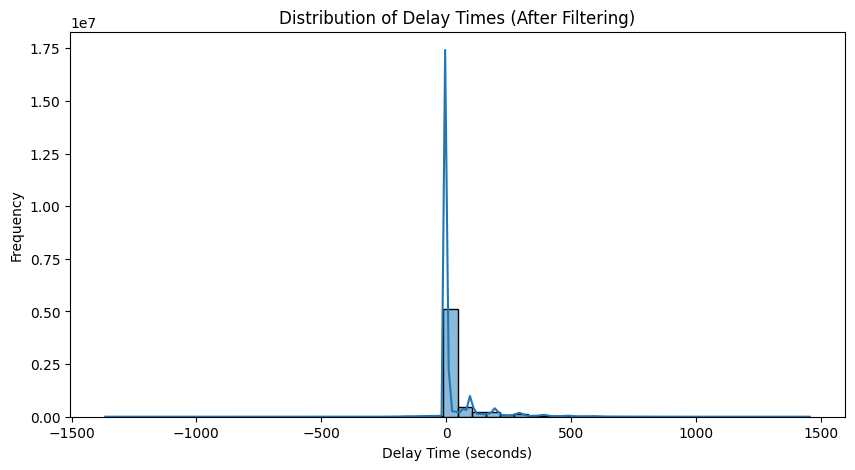

In [53]:
# Replot histogram
plt.figure(figsize=(10, 5))
sns.histplot(stm_trips_df['delay'], bins=50, kde=True)
plt.title('Distribution of Delay Times (After Filtering)')
plt.xlabel('Delay Time (seconds)')
plt.ylabel('Frequency')
plt.savefig('../images/delay_histogram_filtered.png', bbox_inches='tight')
plt.show()

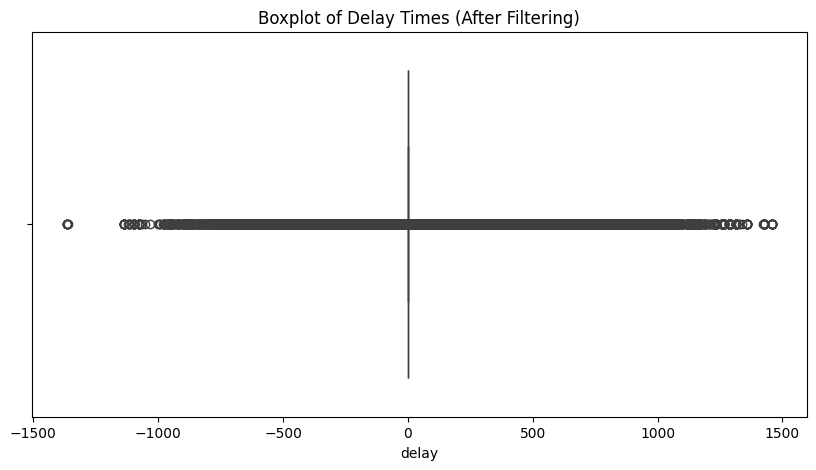

In [54]:
# Replot boxplot
plt.figure(figsize=(10, 5))
sns.boxplot(x=stm_trips_df['delay'])
plt.title('Boxplot of Delay Times (After Filtering)')
plt.savefig('../images/delay_boxplot_filtered.png', bbox_inches='tight')
plt.show()

In [55]:
stm_trips_df.columns

Index(['current_time', 'trip_id', 'route_id', 'start_date', 'stop_id',
       'rt_arrival_time', 'rt_departure_time', 'schedule_relationship',
       'arrival_time', 'departure_time', 'stop_sequence', 'trip_progress',
       'stop_name', 'stop_lat', 'stop_lon', 'location_type', 'parent_station',
       'wheelchair_boarding', 'prev_stop_id', 'exp_trip_duration',
       'exp_delay_prev_stop', 'stop_distance', 'start_date_dt',
       'sch_arrival_time', 'sch_departure_time', 'delay', 'day_of_week',
       'hour'],
      dtype='object')

In [56]:
# Remove uneeded columns
stm_trips_df = stm_trips_df.drop(['current_time', 'arrival_time', 'departure_time', 'start_date_dt', 'day_of_week', 'hour'], axis=1)

### Trips and Traffic Data

In [57]:
# Get proportion of duplicates
duplicate_mask = traffic_df.duplicated()
print(f'{duplicate_mask.mean():.2%}')

36.90%


In [58]:
# Remove duplicates
traffic_df = traffic_df.drop_duplicates(keep='last').reset_index(drop=True)

In [59]:
# Convert traffic start_time and end_time to datetime
traffic_df['start_time'] = pd.to_datetime(traffic_df['start_time'], utc=True)
traffic_df['end_time'] = pd.to_datetime(traffic_df['end_time'], utc=True)

In [60]:
# Sort by date
traffic_df = traffic_df.sort_values(by='start_time').reset_index(drop=True)

In [61]:
# Fill null end times with current time (assuming the incident is still ongoing)
traffic_df['end_time'] = traffic_df['end_time'].fillna(datetime.now(timezone.utc).replace(microsecond=0))
assert traffic_df['end_time'].isna().sum() == 0

In [62]:
# Create GeoDataFrame for trip updates
stm_trips_gdf = gpd.GeoDataFrame(
  stm_trips_df,
  geometry=gpd.points_from_xy(stm_trips_df['stop_lon'], stm_trips_df['stop_lat']),
  crs='EPSG:4326'
).to_crs(epsg=3857)

In [63]:
# Create GeoDataFrame for traffic incidents
traffic_gdf = gpd.GeoDataFrame(
    traffic_df,
    geometry=gpd.points_from_xy(traffic_df['longitude'], traffic_df['latitude']),
    crs='EPSG:4326'
).to_crs(epsg=3857)

In [64]:
# Perform spatial join with nearest incidents
joined = gpd.sjoin_nearest(
  left_df=stm_trips_gdf,
  right_df=traffic_gdf,
  how='left',
  max_distance=500, # get incidents within 500 m
  distance_col='distance')

In [65]:
joined.columns

Index(['trip_id', 'route_id', 'start_date', 'stop_id', 'rt_arrival_time',
       'rt_departure_time', 'schedule_relationship', 'stop_sequence',
       'trip_progress', 'stop_name', 'stop_lat', 'stop_lon', 'location_type',
       'parent_station', 'wheelchair_boarding', 'prev_stop_id',
       'exp_trip_duration', 'exp_delay_prev_stop', 'stop_distance',
       'sch_arrival_time', 'sch_departure_time', 'delay_left', 'geometry',
       'index_right', 'category', 'start_time', 'end_time', 'length',
       'delay_right', 'magnitude_of_delay', 'last_report_time', 'latitude',
       'longitude', 'distance'],
      dtype='object')

In [66]:
# Filter joined incidents by time overlap
active_incident = (joined['start_time'] <= joined['sch_arrival_time']) & (joined['end_time'] >= joined['sch_arrival_time'])
joined = joined[active_incident].copy()

In [67]:
# Group by trip index (from trip_gdf) to attach traffic features
incident_summary = joined.groupby('index_right').agg({
	'category': pd.Series.mode,
	'delay_right': 'mean',
   	'distance': 'mean',
	'magnitude_of_delay': pd.Series.mode,
	'geometry': 'count'  # number of incidents
}).rename(columns={
	'category': 'incident_category',
	'delay_right': 'incident_avg_delay',
  	'distance': 'avg_distance_to_incident',
  	'magnitude_of_delay': 'incident_delay_magnitude',
	'geometry': 'incident_count',
})

In [68]:
# Create boolean column incident_nearby
incident_summary['incident_nearby'] = (incident_summary['incident_count'] > 0).astype('int64')

In [69]:
# Merge back to original trip_updates
trips_traffic_df = stm_trips_gdf.reset_index().merge(incident_summary, left_index=True, right_on='index_right', how='left')

In [70]:
# Fill missing values for trips with no incidents
trips_traffic_df = trips_traffic_df.fillna({
	'incident_category': np.nan,
	'incident_delay': np.nan,
	'avg_distance_to_incident': np.nan,
  	'incident_delay_magnitude': np.nan,
	'incident_count': 0,
	'incident_nearby': 0
})

In [71]:
# Drop uneeded columns
trips_traffic_df = trips_traffic_df.drop(columns=['geometry', 'index_right', 'index'], axis=1)

### Vehicle Positions

In [72]:
# Check if a trip_id is associated with multiple dates
trips_traffic_df.groupby('trip_id')['start_date'].nunique().sort_values(ascending=False)

trip_id
284741582    8
284741581    8
284741542    8
284741545    8
284741547    8
            ..
286594842    1
286594843    1
286594844    1
286594845    1
283211467    1
Name: start_date, Length: 41180, dtype: int64

In [73]:
positions_df.dtypes

current_time        float64
vehicle_id            int64
trip_id               int64
route_id              int64
start_date          float64
start_time           object
latitude            float64
longitude           float64
bearing             float64
speed               float64
stop_sequence         int64
status                int64
timestamp             int64
occupancy_status      int64
dtype: object

In [74]:
# Get null values
positions_df.isna().sum()

current_time         0
vehicle_id           0
trip_id              0
route_id             0
start_date          18
start_time          18
latitude             0
longitude            0
bearing              0
speed                0
stop_sequence        0
status               0
timestamp            0
occupancy_status     0
dtype: int64

In [75]:
# Remove rows will null values
positions_df = positions_df.dropna()

In [76]:
# Convert start_date to int
positions_df['start_date'] = positions_df['start_date'].astype('int64')

In [77]:
# Sort by time
positions_df = positions_df.sort_values('timestamp')

In [78]:
# Get proportion of duplicates
subset = ['trip_id', 'route_id', 'start_date', 'stop_sequence']
duplicate_mask = positions_df.duplicated(subset=subset)
print(f'{duplicate_mask.mean():.2%}')

3.23%


In [79]:
# Drop duplicates
positions_df = positions_df.drop_duplicates(subset=subset, keep='last')

In [80]:
# Rename latitude and longitude
positions_df = positions_df.rename(columns={
  'latitude': 'vehicle_lat',
  'longitude': 'vehicle_lon',
  'status': 'vehicle_status',
  'bearing': 'vehicle_bearing',
  'speed': 'vehicle_speed',
  'timestamp': 'vehicle_dt'
})

In [81]:
# Merge positions
stm_trips_positions_df = pd.merge(left=trips_traffic_df, right=positions_df, how='inner', on=['trip_id', 'route_id', 'start_date', 'stop_sequence']) 

In [82]:
stm_trips_positions_df.columns

Index(['trip_id', 'route_id', 'start_date', 'stop_id', 'rt_arrival_time',
       'rt_departure_time', 'schedule_relationship', 'stop_sequence',
       'trip_progress', 'stop_name', 'stop_lat', 'stop_lon', 'location_type',
       'parent_station', 'wheelchair_boarding', 'prev_stop_id',
       'exp_trip_duration', 'exp_delay_prev_stop', 'stop_distance',
       'sch_arrival_time', 'sch_departure_time', 'delay', 'incident_category',
       'incident_avg_delay', 'avg_distance_to_incident',
       'incident_delay_magnitude', 'incident_count', 'incident_nearby',
       'current_time', 'vehicle_id', 'start_time', 'vehicle_lat',
       'vehicle_lon', 'vehicle_bearing', 'vehicle_speed', 'vehicle_status',
       'vehicle_dt', 'occupancy_status'],
      dtype='object')

In [83]:
# Create GeoDataFrames for vehicle and stop positions
pos_gdf1 = gpd.GeoDataFrame(
  stm_trips_positions_df[['vehicle_lon', 'vehicle_lat']],
  geometry=gpd.points_from_xy(stm_trips_positions_df['vehicle_lon'], stm_trips_positions_df['vehicle_lat']),
  crs='EPSG:4326'
).to_crs(epsg=3857)

pos_gdf2 = gpd.GeoDataFrame(
  stm_trips_positions_df[['stop_lon', 'stop_lat']],
  geometry=gpd.points_from_xy(stm_trips_positions_df['stop_lon'], stm_trips_positions_df['stop_lat']),
  crs='EPSG:4326'
).to_crs(epsg=3857)

In [84]:
# Calculate the vehicle distance from the current stop
stm_trips_positions_df['vehicle_distance'] = pos_gdf1.distance(pos_gdf2)
stm_trips_positions_df['vehicle_distance'].describe()

count    5.053170e+05
mean     4.687088e+02
std      3.142478e+04
min      3.001229e-02
25%      1.118834e+01
50%      1.560524e+02
75%      3.371461e+02
max      9.988454e+06
Name: vehicle_distance, dtype: float64

In [85]:
# The large vehicle distances don't seem to make sense with the delays, the coordinates and distance won't be used
further_than_previous_stop = stm_trips_positions_df['vehicle_distance'] > stm_trips_positions_df['stop_distance']
stm_trips_positions_df[further_than_previous_stop].sort_values('vehicle_distance', ascending=False)

,trip_id,route_id,start_date,stop_id,rt_arrival_time,rt_departure_time,schedule_relationship,stop_sequence,trip_progress,stop_name,...,vehicle_id,start_time,vehicle_lat,vehicle_lon,vehicle_bearing,vehicle_speed,vehicle_status,vehicle_dt,occupancy_status,vehicle_distance
355562,283854581,192,20250504,54882,2025-05-04 20:28:19+00:00,2025-05-04 20:28:19+00:00,0,20,0.408163,Robert / Aimé-Renaud,...,36040,16:14:00,0.001783,-0.002900,0.0,2.50002,2,1746390571,1,9.988454e+06
168445,285031853,49,20250430,53684,2025-05-01 00:29:46+00:00,2025-05-01 00:29:46+00:00,0,40,0.645161,Perras / 49e Avenue,...,36031,19:40:00,0.031000,-0.050567,312.0,8.61118,2,1746060348,1,9.986185e+06
167418,285031853,49,20250430,53684,2025-05-01 00:24:22+00:00,2025-05-01 00:24:22+00:00,0,40,0.645161,Perras / 49e Avenue,...,36031,19:40:00,0.031000,-0.050567,312.0,8.61118,2,1746060348,1,9.986185e+06
394397,286574314,420,20250505,52588,2025-05-05 19:44:00+00:00,2025-05-05 19:44:00+00:00,0,4,0.190476,Robert-Bourassa / René-Lévesque,...,29141,15:32:00,0.000150,-0.000233,312.0,1.11112,2,1746474285,1,9.978395e+06
182897,286570760,71,20250501,53049,2025-05-01 12:14:13+00:00,2025-05-01 12:14:13+00:00,0,17,0.500000,Ash / Dick-Irvin,...,30032,07:54:00,0.000250,-0.000383,312.0,7.22228,2,1746101735,1,9.974662e+06
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
432677,285010172,419,20250506,57822,NaT,2025-05-06 14:30:00+00:00,0,1,0.052632,Brunswick / Terminus Fairview,...,31195,10:30:00,45.466579,-73.830933,57.0,0.00000,1,1746541792,1,8.144308e-02
376791,285010182,419,20250505,57822,NaT,2025-05-05 13:31:00+00:00,0,1,0.052632,Brunswick / Terminus Fairview,...,40162,09:31:00,45.466579,-73.830933,0.0,0.00000,1,1746451772,1,8.144308e-02
255869,285010186,419,20250502,57822,NaT,2025-05-02 15:17:00+00:00,0,1,0.052632,Brunswick / Terminus Fairview,...,31168,11:17:00,45.466579,-73.830933,0.0,0.00000,1,1746198944,1,8.144308e-02
63290,285010143,419,20250429,57822,NaT,2025-04-29 12:46:00+00:00,0,1,0.052632,Brunswick / Terminus Fairview,...,40202,08:46:00,45.466579,-73.830933,0.0,0.00000,1,1745930724,1,8.144308e-02


### Service Alerts

In [86]:
# Get proportion of duplicates
duplicate_mask = alerts_df.duplicated()
print(f'{duplicate_mask.mean():.2%}')

83.14%


In [87]:
# Remove duplicates
alerts_df = alerts_df.drop_duplicates(keep='last').reset_index(drop=True)

In [88]:
# Convert timestamps to datetime
alerts_df['start_time'] = pd.to_datetime(alerts_df['start_time'], origin='unix', unit='s', utc=True)
alerts_df['end_time'] = pd.to_datetime(alerts_df['end_time'], origin='unix', unit='s', utc=True)

In [89]:
# Fill null end times with current dates (assuming the alert is still active)
alerts_df['end_time'] = alerts_df['end_time'].fillna(datetime.now(timezone.utc).replace(microsecond=0))

In [90]:
# Sort values by start time
alerts_df = alerts_df.sort_values('start_time').reset_index(drop=True)

In [91]:
# Merge alerts with current stop
stm_df = pd.merge(left=stm_trips_positions_df, right=alerts_df, how='left', on=['route_id', 'stop_id'])

In [92]:
stm_df.columns

Index(['trip_id', 'route_id', 'start_date', 'stop_id', 'rt_arrival_time',
       'rt_departure_time', 'schedule_relationship', 'stop_sequence',
       'trip_progress', 'stop_name', 'stop_lat', 'stop_lon', 'location_type',
       'parent_station', 'wheelchair_boarding', 'prev_stop_id',
       'exp_trip_duration', 'exp_delay_prev_stop', 'stop_distance',
       'sch_arrival_time', 'sch_departure_time', 'delay', 'incident_category',
       'incident_avg_delay', 'avg_distance_to_incident',
       'incident_delay_magnitude', 'incident_count', 'incident_nearby',
       'current_time', 'vehicle_id', 'start_time_x', 'vehicle_lat',
       'vehicle_lon', 'vehicle_bearing', 'vehicle_speed', 'vehicle_status',
       'vehicle_dt', 'occupancy_status', 'vehicle_distance', 'start_time_y',
       'end_time'],
      dtype='object')

In [93]:
# Merge alerts with previous stop
stm_df = pd.merge(left=stm_df, right=alerts_df, how='left', left_on=['route_id', 'prev_stop_id'], right_on=['route_id', 'stop_id'])

In [94]:
stm_df.columns

Index(['trip_id', 'route_id', 'start_date', 'stop_id_x', 'rt_arrival_time',
       'rt_departure_time', 'schedule_relationship', 'stop_sequence',
       'trip_progress', 'stop_name', 'stop_lat', 'stop_lon', 'location_type',
       'parent_station', 'wheelchair_boarding', 'prev_stop_id',
       'exp_trip_duration', 'exp_delay_prev_stop', 'stop_distance',
       'sch_arrival_time', 'sch_departure_time', 'delay', 'incident_category',
       'incident_avg_delay', 'avg_distance_to_incident',
       'incident_delay_magnitude', 'incident_count', 'incident_nearby',
       'current_time', 'vehicle_id', 'start_time_x', 'vehicle_lat',
       'vehicle_lon', 'vehicle_bearing', 'vehicle_speed', 'vehicle_status',
       'vehicle_dt', 'occupancy_status', 'vehicle_distance', 'start_time_y',
       'end_time_x', 'start_time', 'end_time_y', 'stop_id_y'],
      dtype='object')

In [95]:
# Add boolean column if the previous or current stop as an active alert
current_stop_mask = (stm_df['start_time_y'].notna()) & \
	(stm_df['sch_arrival_time'] >= stm_df['start_time_y']) & \
	(stm_df['sch_arrival_time'] <= stm_df['end_time_x'])

previous_stop_mask = (stm_df['start_time'].notna()) & \
	(stm_df['sch_arrival_time'] >= stm_df['start_time']) & \
	(stm_df['sch_arrival_time'] <= stm_df['end_time_y'])

stm_df['stop_has_alert'] = (current_stop_mask | previous_stop_mask).astype('int64')

In [96]:
stm_df['stop_has_alert'].value_counts()

stop_has_alert
0    477046
1     85971
Name: count, dtype: int64

In [97]:
# Rename and drop unneeded columns
stm_df = stm_df.rename(columns={'stop_id_x': 'stop_id'}).drop([
  'start_time_x',
  'start_time_y',
  'start_time',
  'end_time_x',
  'end_time_y',
  'stop_id_y'
  ], axis=1)

### Route Types

In [98]:
stm_df = pd.merge(left=stm_df, right=routes_df, how='inner', on='route_id')

In [99]:
stm_df.columns

Index(['trip_id', 'route_id', 'start_date', 'stop_id', 'rt_arrival_time',
       'rt_departure_time', 'schedule_relationship', 'stop_sequence',
       'trip_progress', 'stop_name', 'stop_lat', 'stop_lon', 'location_type',
       'parent_station', 'wheelchair_boarding', 'prev_stop_id',
       'exp_trip_duration', 'exp_delay_prev_stop', 'stop_distance',
       'sch_arrival_time', 'sch_departure_time', 'delay', 'incident_category',
       'incident_avg_delay', 'avg_distance_to_incident',
       'incident_delay_magnitude', 'incident_count', 'incident_nearby',
       'current_time', 'vehicle_id', 'vehicle_lat', 'vehicle_lon',
       'vehicle_bearing', 'vehicle_speed', 'vehicle_status', 'vehicle_dt',
       'occupancy_status', 'vehicle_distance', 'stop_has_alert', 'route_type'],
      dtype='object')

### STM and Weather

In [100]:
# Convert time string to datetime
time_dt = pd.to_datetime(weather_df['time'], utc=True)

In [101]:
# Calculate dates for weather forecast
last_day_weather = time_dt.max()
start_date = last_day_weather + timedelta(days=1)
end_date = stm_df['sch_arrival_time'].max()

In [102]:
# Fetch forecast weather
start_date_str = start_date.strftime('%Y-%m-%d')
end_date_str = end_date.strftime('%Y-%m-%d')

forecast_list = fetch_weather(start_date=start_date_str, end_date=end_date_str, forecast=True)
forecast_df = pd.DataFrame(forecast_list)

In [103]:
# Merge archive and forecast weather
weather_df = pd.concat([weather_df, forecast_df], ignore_index=True)

In [104]:
weather_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 263 entries, 0 to 262
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   time               263 non-null    object 
 1   temperature        263 non-null    float64
 2   relative_humidity  263 non-null    int64  
 3   dew_point          263 non-null    float64
 4   precipitation      263 non-null    float64
 5   pressure           263 non-null    float64
 6   visibility         72 non-null     float64
 7   cloud_cover        263 non-null    int64  
 8   windspeed          263 non-null    float64
 9   wind_direction     263 non-null    int64  
 10  wind_gusts         263 non-null    float64
dtypes: float64(7), int64(3), object(1)
memory usage: 22.7+ KB


In [105]:
# Drop visibility column because most of the values are null
weather_df = weather_df.drop('visibility', axis=1)

In [106]:
# Round arrival time to the nearest hour
rounded_arrival_dt = stm_df['sch_arrival_time'].dt.round('h')

In [107]:
# Format time to match weather data
stm_df['time'] = rounded_arrival_dt.dt.strftime('%Y-%m-%dT%H:%M')

In [108]:
# Merge STM with weather
df = pd.merge(left=stm_df, right=weather_df, how='inner', on='time').drop('time', axis=1)

## Clean Data

### Drop Columns

In [109]:
# Remove columns with constant values or with more than 50% missing values
df = df.loc[:, (df.nunique() > 1) & (df.isna().mean() < 0.5)]
df.columns

Index(['trip_id', 'route_id', 'start_date', 'stop_id', 'rt_arrival_time',
       'rt_departure_time', 'schedule_relationship', 'stop_sequence',
       'trip_progress', 'stop_name', 'stop_lat', 'stop_lon',
       'wheelchair_boarding', 'prev_stop_id', 'exp_trip_duration',
       'exp_delay_prev_stop', 'stop_distance', 'sch_arrival_time',
       'sch_departure_time', 'delay', 'incident_count', 'incident_nearby',
       'current_time', 'vehicle_id', 'vehicle_lat', 'vehicle_lon',
       'vehicle_bearing', 'vehicle_speed', 'vehicle_status', 'vehicle_dt',
       'occupancy_status', 'vehicle_distance', 'stop_has_alert', 'route_type',
       'temperature', 'relative_humidity', 'dew_point', 'precipitation',
       'pressure', 'cloud_cover', 'windspeed', 'wind_direction', 'wind_gusts'],
      dtype='object')

In [110]:
df.isna().sum()

trip_id                      0
route_id                     0
start_date                   0
stop_id                      0
rt_arrival_time          52110
rt_departure_time        65955
schedule_relationship        0
stop_sequence                0
trip_progress                0
stop_name                    0
stop_lat                     0
stop_lon                     0
wheelchair_boarding          0
prev_stop_id             51987
exp_trip_duration            0
exp_delay_prev_stop          0
stop_distance                0
sch_arrival_time             0
sch_departure_time           0
delay                        0
incident_count               0
incident_nearby              0
current_time                 0
vehicle_id                   0
vehicle_lat                  0
vehicle_lon                  0
vehicle_bearing              0
vehicle_speed                0
vehicle_status               0
vehicle_dt                   0
occupancy_status             0
vehicle_distance             0
stop_has

### Convert columns

In [111]:
# Get columns with two values
two_values = df.loc[:, df.nunique() == 2]
for column in two_values.columns:
  print(df[column].value_counts())

wheelchair_boarding
1    531183
2     29203
Name: count, dtype: int64
incident_nearby
0.0    559089
1.0      1297
Name: count, dtype: int64
vehicle_status
2    398811
1    161575
Name: count, dtype: int64
stop_has_alert
0    474867
1     85519
Name: count, dtype: int64


In [112]:
# Convert columns with 2 unique values to integer
df['wheelchair_boarding'] = (df['wheelchair_boarding'] == 1).astype('int64')
df['vehicle_in_transit'] = (df['vehicle_status'] == 2).astype('int64')
df['incident_nearby'] = df['incident_nearby'].astype('int64')

### Create Delay Categories

**Delay Threshholds, according to [STM's definition](https://www.stm.info/en/info/networks/bus-network-and-schedules-enlightened)**

- Early: delay < -1 min
- On Time: -1 min ≤ delay < 3 min
- Late: delay ≥ 3 min

In [113]:
# Add delay category column
labels = ['Early', 'On Time', 'Late']
ranges = [-np.inf, -60, 180, np.inf]
df['delay_class'] = pd.cut(df['delay'], bins=ranges, labels=labels, include_lowest=True, right=False)
df['delay_class'].value_counts(normalize=True)

delay_class
On Time    0.878307
Late       0.097058
Early      0.024635
Name: proportion, dtype: float64

### Convert schedule_relationship and occupancy_status to Categories

In [114]:
def convert_to_categories(df:pd.DataFrame, column:str, map_dict:dict) -> pd.Series:
	codes = df[column].sort_values().unique()
	condition_list = []
	label_list = []
		
	for code in codes:
		condition_list.append(df[column] == code)
		label_list.append(map_dict[code])
	
	df[column] = np.select(condition_list, label_list, default='Unknown')
	return df[column]

In [115]:
df['schedule_relationship'] = convert_to_categories(df, 'schedule_relationship', SCHEDULE_RELATIONSHIP)
df['schedule_relationship'].value_counts()

schedule_relationship
Scheduled    557850
No Data        1754
Skipped         782
Name: count, dtype: int64

In [116]:
df['occupancy_status'] = convert_to_categories(df, 'occupancy_status', OCCUPANCY_STATUS)
df['occupancy_status'].value_counts()

occupancy_status
Empty                         267815
Many seats available          169909
Few seats available           114167
Crushed standing room only      8132
Unknown                          363
Name: count, dtype: int64

## Export Data

In [117]:
df.columns

Index(['trip_id', 'route_id', 'start_date', 'stop_id', 'rt_arrival_time',
       'rt_departure_time', 'schedule_relationship', 'stop_sequence',
       'trip_progress', 'stop_name', 'stop_lat', 'stop_lon',
       'wheelchair_boarding', 'prev_stop_id', 'exp_trip_duration',
       'exp_delay_prev_stop', 'stop_distance', 'sch_arrival_time',
       'sch_departure_time', 'delay', 'incident_count', 'incident_nearby',
       'current_time', 'vehicle_id', 'vehicle_lat', 'vehicle_lon',
       'vehicle_bearing', 'vehicle_speed', 'vehicle_status', 'vehicle_dt',
       'occupancy_status', 'vehicle_distance', 'stop_has_alert', 'route_type',
       'temperature', 'relative_humidity', 'dew_point', 'precipitation',
       'pressure', 'cloud_cover', 'windspeed', 'wind_direction', 'wind_gusts',
       'vehicle_in_transit', 'delay_class'],
      dtype='object')

In [118]:
# Drop and reorder columns
df = df[[
	'trip_id',
  	'exp_trip_duration',
	'vehicle_id',
  	'vehicle_bearing',
	'vehicle_speed',
	'vehicle_in_transit',
	'occupancy_status',
  	'route_id',
    'route_type',
  	'stop_id',
    'stop_name',
    'stop_lat',
    'stop_lon',
    'stop_distance',
    'stop_sequence',
    'trip_progress',
    'stop_has_alert',
    'schedule_relationship',
	'wheelchair_boarding',
  	'rt_arrival_time',
	'rt_departure_time',
  	'sch_arrival_time',
    'sch_departure_time',
    'delay',
    'delay_class',
    'exp_delay_prev_stop',
    'incident_count',
    'incident_nearby',
	'temperature',
    'relative_humidity',
  	'dew_point',
  	'precipitation',
  	'pressure',
	'cloud_cover',
  	'windspeed',
  	'wind_direction',
  	'wind_gusts'
]]

In [119]:
# Export data to CSV
df.to_parquet('../data/stm_weather_traffic_merged.parquet', index=False)

## End